In [1]:
from gerrychain import Graph

In [2]:
# Read New Mexico county graph from the json file "NM_county.json"
filepath = 'C:\\Users\\loryn\\OneDrive\\Documents\\Python Scripts\\Operations Research\\'
filename = 'NM_county.json'

# GerryChain has a build-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename)

# Print the nodes
print("The New Mexico county graph has nodes =", G.nodes)

The New Mexico county graph has nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [3]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts


# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node", node, "represents", county_name, "County which had a population of", county_population,"in the 2020 cencus.")

total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes) # Population of New Mexico

print("\nThe total population of New Mexico is", total_population)

L = math.ceil((1-deviation/2)*total_population/k)  # Lower Bound of District Population
U = math.floor((1+deviation/2)*total_population/k) # Upper Bound of District Population

print("\nUsing L =",L,"and U =",U,"and k =",k)

Node 0 represents Curry County which had a population of 48430 in the 2020 cencus.
Node 1 represents Roosevelt County which had a population of 19191 in the 2020 cencus.
Node 2 represents San Juan County which had a population of 121661 in the 2020 cencus.
Node 3 represents Lincoln County which had a population of 20269 in the 2020 cencus.
Node 4 represents Guadalupe County which had a population of 4452 in the 2020 cencus.
Node 5 represents Torrance County which had a population of 15045 in the 2020 cencus.
Node 6 represents Luna County which had a population of 25427 in the 2020 cencus.
Node 7 represents McKinley County which had a population of 72902 in the 2020 cencus.
Node 8 represents Rio Arriba County which had a population of 40363 in the 2020 cencus.
Node 9 represents Lea County which had a population of 74455 in the 2020 cencus.
Node 10 represents Chaves County which had a population of 65157 in the 2020 cencus.
Node 11 represents Santa Fe County which had a population of 154

In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-17


In [5]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [6]:
# add constraints saying that each county i is assigned to one and only one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district must have a population between L and U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [7]:
# CONTIGUITY CONSTRAINTS!!!
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [8]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [9]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0x4d991e6b
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.00s
Presolved: 486 rows, 432 columns, 1950 nonzeros
Variable types: 156 continuous, 276 integer (276 binary)

Root relaxation: objective 0.000000e+00, 188 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  108          -    0.00000      -     -    0s
     0     0    3.527

In [10]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

# What is the population deviation for this model?
population_deviation = max(district_populations) - min(district_populations)
print("\nThe population deviation for this model is", population_deviation, "people.")

The number of cut edges is 19.0
District 0 has population 702632 and contains counties ['Curry', 'San Juan', 'Guadalupe', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Quay', 'Union', 'San Miguel', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']
District 1 has population 707195 and contains counties ['Bernalillo', 'Catron', 'Cibola']
District 2 has population 707695 and contains counties ['Roosevelt', 'Lincoln', 'Torrance', 'Luna', 'Lea', 'Chaves', 'Sierra', 'Valencia', 'De Baca', 'Otero', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

The population deviation for this model is 5063 people.


In [11]:
# MAP TIME!!!
import geopandas as gpd

In [12]:
# Read New Mexico county shapefile from "NM_county.shp"
filepath = 'C:\\Users\\loryn\\OneDrive\\Documents\\Python Scripts\\Operations Research\\'
filename = "NM_county.shp"


# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

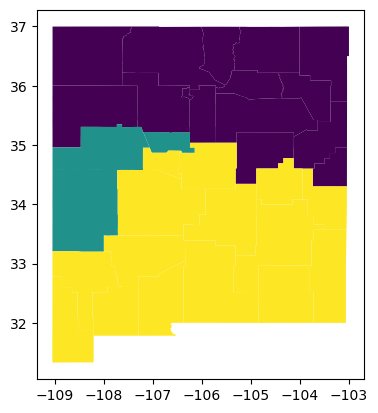

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID20"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID20'][u]:
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()